# Day 6: Regime Switching Models

## 🎯 Learning Objectives
- Understand Hidden Markov Models
- Implement Markov Switching models
- Apply to regime-dependent trading

---

## 📚 Theory: Markov Switching

### Model
$$y_t | S_t = s \sim N(\mu_s, \sigma_s^2)$$
$$P(S_t = j | S_{t-1} = i) = p_{ij}$$

### Key Concept
Parameters depend on unobserved regime state $S_t$.

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=15*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna() * 100  # Percentage

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 3769 days


In [2]:
# Fit 2-state Markov Switching Model
print("\n🔄 Fitting Markov Switching Model (this may take a moment)...")

model = MarkovRegression(returns, k_regimes=2, switching_variance=True)
fitted = model.fit()

print("\n" + "="*60)
print("MARKOV SWITCHING MODEL RESULTS")
print("="*60)
print(fitted.summary())


🔄 Fitting Markov Switching Model (this may take a moment)...

MARKOV SWITCHING MODEL RESULTS
                        Markov Switching Model Results                        
Dep. Variable:                    SPY   No. Observations:                 3768
Model:               MarkovRegression   Log Likelihood               -4890.232
Date:                Fri, 23 Jan 2026   AIC                           9792.464
Time:                        00:07:03   BIC                           9829.870
Sample:                             0   HQIC                          9805.764
                               - 3768                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1151      0.013     

In [3]:
# Extract regime parameters
print("\n" + "="*60)
print("REGIME PARAMETERS")
print("="*60)

# Regime means
means = fitted.params[['const[0]', 'const[1]']]
# Regime variances
vars_ = fitted.params[['sigma2[0]', 'sigma2[1]']]

for i in range(2):
    print(f"\nRegime {i}:")
    print(f"  Mean: {fitted.params[f'const[{i}]']:.4f}%")
    print(f"  Std: {np.sqrt(fitted.params[f'sigma2[{i}]']):.4f}%")

# Identify regimes
if fitted.params['const[0]'] > fitted.params['const[1]']:
    regime_names = {0: 'Bull', 1: 'Bear'}
else:
    regime_names = {0: 'Bear', 1: 'Bull'}


REGIME PARAMETERS

Regime 0:
  Mean: 0.1151%
  Std: 0.6009%

Regime 1:
  Mean: -0.0723%
  Std: 1.7217%


In [4]:
# Smoothed regime probabilities
smoothed_probs = fitted.smoothed_marginal_probabilities

df = pd.DataFrame(index=returns.index)
df['return'] = returns.values
df['prob_regime0'] = smoothed_probs.iloc[:, 0].values
df['prob_regime1'] = smoothed_probs.iloc[:, 1].values
df['regime'] = np.argmax(smoothed_probs.values, axis=1)
df['regime_name'] = df['regime'].map(regime_names)

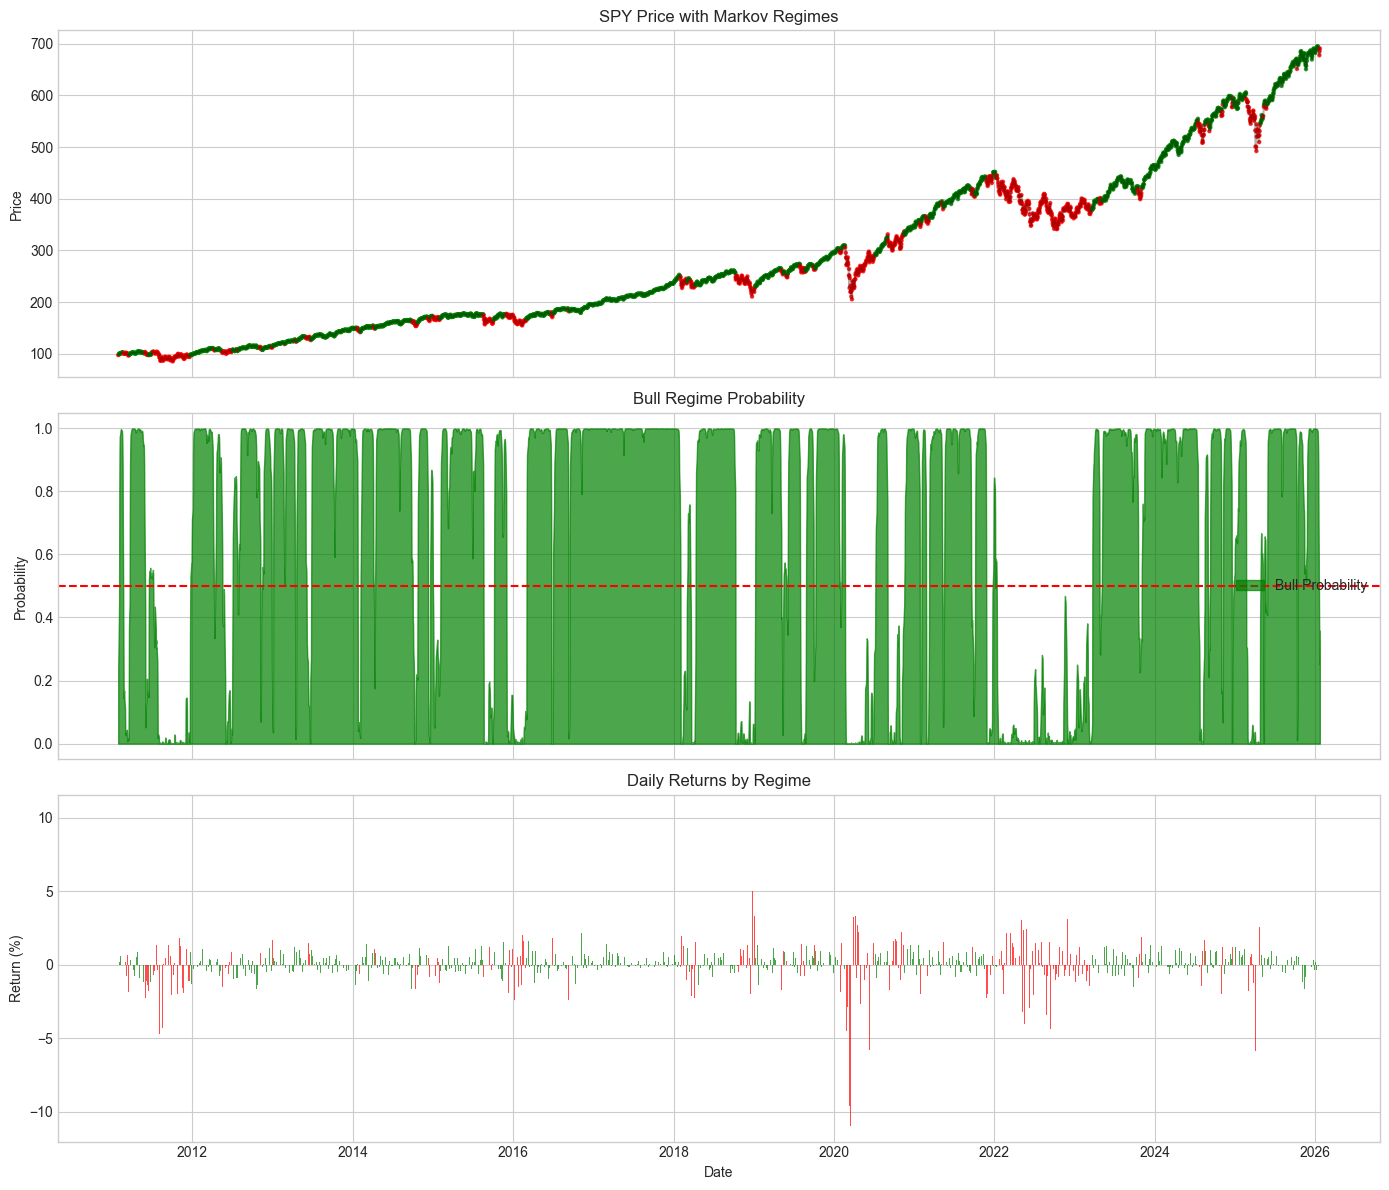

In [5]:
# Visualize regimes
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Price with regime coloring
price_aligned = prices.loc[df.index]
colors = {'Bull': 'green', 'Bear': 'red'}
regime_colors = [colors[df['regime_name'].iloc[i]] for i in range(len(df))]

axes[0].plot(price_aligned.index, price_aligned.values, 'k-', alpha=0.3)
axes[0].scatter(df.index, price_aligned.values, c=regime_colors, s=5, alpha=0.7)
axes[0].set_title(f'{ticker} Price with Markov Regimes')
axes[0].set_ylabel('Price')

# Regime probability
bull_idx = 0 if regime_names[0] == 'Bull' else 1
axes[1].fill_between(df.index, df[f'prob_regime{bull_idx}'], alpha=0.7, color='green', label='Bull Probability')
axes[1].axhline(y=0.5, color='r', linestyle='--')
axes[1].set_title('Bull Regime Probability')
axes[1].set_ylabel('Probability')
axes[1].legend()

# Returns by regime
axes[2].bar(df.index, df['return'], color=regime_colors, alpha=0.7)
axes[2].set_title('Daily Returns by Regime')
axes[2].set_ylabel('Return (%)')
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [6]:
# Transition matrix
print("\n" + "="*60)
print("TRANSITION MATRIX")
print("="*60)

trans_matrix = fitted.regime_transition
print(f"\n{'':<15} {'To Regime 0':>15} {'To Regime 1':>15}")
print("-" * 45)
print(f"{'From Regime 0':<15} {trans_matrix[0, 0].item():>15.4f} {trans_matrix[0, 1].item():>15.4f}")
print(f"{'From Regime 1':<15} {trans_matrix[1, 0].item():>15.4f} {trans_matrix[1, 1].item():>15.4f}")

# Expected duration
for i in range(2):
    duration = 1 / (1 - trans_matrix[i, i].item())
    print(f"\nExpected Duration in {regime_names[i]}: {duration:.1f} days")


TRANSITION MATRIX

                    To Regime 0     To Regime 1
---------------------------------------------
From Regime 0            0.9772          0.0505
From Regime 1            0.0228          0.9495

Expected Duration in Bull: 43.9 days

Expected Duration in Bear: 19.8 days


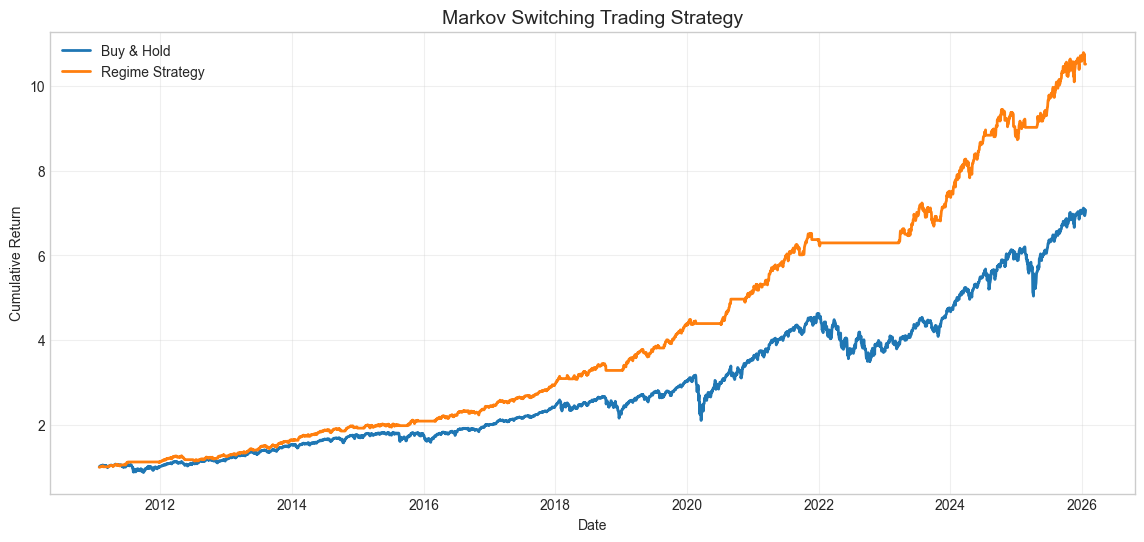

In [7]:
# Regime-based trading strategy
df['next_return'] = df['return'].shift(-1) / 100  # Decimal

# Strategy: Long in Bull, Out in Bear
bull_idx = 0 if regime_names[0] == 'Bull' else 1
df['signal'] = np.where(df[f'prob_regime{bull_idx}'] > 0.5, 1, 0)

df['strategy_return'] = df['signal'] * df['next_return']
df = df.dropna()

df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['buy_hold_cum'] = (1 + df['next_return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(df.index, df['strategy_cum'], label='Regime Strategy', linewidth=2)
plt.title('Markov Switching Trading Strategy', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

bh_total, bh_sharpe, bh_mdd = calc_metrics(df['next_return'], df['buy_hold_cum'])
st_total, st_sharpe, st_mdd = calc_metrics(df['strategy_return'], df['strategy_cum'])

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)
print(f"{'Buy & Hold':<20} {bh_total:>12.2%} {bh_sharpe:>10.2f} {bh_mdd:>10.2%}")
print(f"{'Regime Strategy':<20} {st_total:>12.2%} {st_sharpe:>10.2f} {st_mdd:>10.2%}")

# Time in market
time_in_market = df['signal'].mean()
print(f"\nTime in Market: {time_in_market:.1%}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                606.86%       0.56    -33.72%
Regime Strategy           951.23%       1.33     -9.66%

Time in Market: 69.8%


In [9]:
# Current regime signal
print("\n" + "="*60)
print(f"📊 MARKOV REGIME SIGNAL FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
price_val = float(prices.iloc[-1].iloc[0]) if hasattr(prices.iloc[-1], 'iloc') else float(prices.iloc[-1])
print(f"Current Price: ${price_val:.2f}")

bull_prob = df[f'prob_regime{bull_idx}'].iloc[-1]
bear_prob = 1 - bull_prob
current_regime = df['regime_name'].iloc[-1]

print(f"\nRegime Probabilities:")
print(f"  Bull: {bull_prob:.1%}")
print(f"  Bear: {bear_prob:.1%}")
print(f"\nCurrent Regime: {current_regime}")
print(f"\n🎯 Signal: {'📈 LONG' if bull_prob > 0.5 else '💵 CASH'}")


📊 MARKOV REGIME SIGNAL FOR SPY

Date: 2026-01-21
Current Price: $690.64

Regime Probabilities:
  Bull: 30.1%
  Bear: 69.9%

Current Regime: Bear

🎯 Signal: 💵 CASH


---

## 🏢 Real-World Applications

| Company | Regime Switching Use |
|---------|---------------------|
| Bridgewater | Economic regime models |
| GMO | Asset allocation |
| Research Affiliates | Return forecasting |

---
## 📅 Tomorrow: Week 10 Review